# Preview Evaluation - Perplexity

Thia is a notebook to make a preview comparison of the generations when using LLM JUDGE

In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from utils.metrics.calculate_metric import calculate_agg_metric
import os
import numpy as np
import json
from pathlib import Path
PATH = Path(os.getcwd()).parent.parent.parent

/home/users/caio.rhoden/miniconda3/envs/nq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 10-10 16:53:18 [__init__.py:220] No platform detected, vLLM is running on UnspecifiedPlatform
WARNING 10-10 16:53:19 [_custom_ops.py:20] Failed to import from vllm._C with ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')


In [2]:
models = [
    "Qwen3-4B-Instruct-2507",
    "Llama-3.2-3B-Instruct"
]

## Calculate Metrics and save them

In [3]:
from concurrent.futures import ThreadPoolExecutor
import os

questions_path = f"{PATH}/data/nq_open_gold/processed/test.feather"

def process_file(m, file):
    output_file = f"result_{m}_{file.split('.')[0]}.feather"
    if output_file not in os.listdir("."):
        print(f"Processing {m}/{file}")
        calculate_agg_metric(
            metrics=["rouge_l"],
            generation_path=f"../{m}/generations/{file}",
            reference_path=questions_path,
            saving_path=output_file
        )
        return f"✓ {m}/{file}"
    return f"⚠ Skipped {m}/{file} (already exists)"

# Process each model sequentially, but files within each model in parallel
for m in models:
    generation_files = os.listdir(f"../{m}/generations")
    print(f"\nProcessing model: {m} ({len(generation_files)} files)")
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(lambda f: process_file(m, f), generation_files))
        for result in results:
            print(result)


Processing model: Qwen3-4B-Instruct-2507 (4 files)
⚠ Skipped Qwen3-4B-Instruct-2507/zero_shot_Qwen3-4B-Instruct-2507_baseline_zero_shot_generations.json (already exists)
⚠ Skipped Qwen3-4B-Instruct-2507/rag_0_2889_rag_generations.json (already exists)
⚠ Skipped Qwen3-4B-Instruct-2507/rougel_model.json (already exists)
⚠ Skipped Qwen3-4B-Instruct-2507/judge_model.json (already exists)

Processing model: Llama-3.2-3B-Instruct (3 files)
⚠ Skipped Llama-3.2-3B-Instruct/zero_shot_Llama-3.2-3B-Instruct_baseline_zero_shot_generations.json (already exists)
⚠ Skipped Llama-3.2-3B-Instruct/rag_0_2889_rag_generations.json (already exists)
⚠ Skipped Llama-3.2-3B-Instruct/rougel_model.json (already exists)


## Load Data

In [4]:
results = []
for f in os.listdir("."):
    if f.endswith("feather"):
        processsed_namefile = f.split(".f")[0].split("result_")[1]
        run_type = processsed_namefile
        results.append(pl.read_ipc(f).with_columns(pl.lit(run_type).alias("run_type")))
perplexity_results = pl.concat(results)
perplexity_results.group_by("run_type", "metric").agg(pl.col("mean").mean()).sort("run_type")

Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.
Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


run_type,metric,mean
str,str,f64
"""Llama-3.2-3B-Instruct_rag_0_28…","""rouge_l""",0.16188
"""Llama-3.2-3B-Instruct_rougel_m…","""rouge_l""",0.222273
"""Llama-3.2-3B-Instruct_zero_sho…","""rouge_l""",0.295839
"""Qwen3-4B-Instruct-2507_judge_m…","""rouge_l""",0.158645
"""Qwen3-4B-Instruct-2507_rag_0_2…","""rouge_l""",0.111325
"""Qwen3-4B-Instruct-2507_rougel_…","""rouge_l""",0.159904
"""Qwen3-4B-Instruct-2507_zero_sh…","""rouge_l""",0.187763


In [ ]:
import json
indexes = {}
for m in models:
    indexes[m] = []
    rag_retrieval = json.load(open(f"../retrieval/rag_retrieval_indexes.json"))
    rouge = json.load(open("../retrieval/rougel_model_indexes.json"))
    judge = json.load(open("../retrieval/judge_model_indexes.json"))
    dicts = [rag_retrieval, rouge, judge]
    processed_dicts = []
    for d in dicts:
        # Get values in order and convert to numpy arrayzz
        array_50x100 = np.array([d[str(key)] for key in range(50)])
        # Take first 16 elements
        array_50x16 = array_50x100[:, 34:50]
        # Convert back to list if needed (otherwise keep as numpy array)
        processed_dicts.append(array_50x16.tolist())
    indexes[m] = processed_dicts

In [20]:
len(indexes["655"])

3

In [21]:

s = "655"
def count_matches_no_numpy(list_a, list_b):
    matches = 0
    for key in range(50):
        for i in range(16):
            if list_a[key][i] in list_b[key]:
                matches += 1
    return matches

def count_matches_no_numpy_3(list_a, list_b, list_c):
    matches = 0
    for key in range(50):
        for i in range(16):
            if list_a[key][i] in list_b[key] and list_a[key][i] in list_c[key]:
                matches += 1
    return matches



print(f"Seed: {s}")
print(f"Intersection between RAG and Datamodels: {count_matches_no_numpy(indexes[str(s)][0], indexes[str(s)][1])}")
print(f"Intersection between RAG and LLM Judge: {count_matches_no_numpy(indexes[str(s)][0], indexes[str(s)][2])}")
print(f"Intersection between Datamodels and LLM Judge: {count_matches_no_numpy(indexes[str(s)][1], indexes[str(s)][2])}")
print(f"Intersection between RAG, Datamodels and LLM Judge: {count_matches_no_numpy_3(indexes[str(s)][0], indexes[str(s)][1], indexes[str(s)][2])}")

Seed: 655
Intersection between RAG and Datamodels: 98
Intersection between RAG and LLM Judge: 86
Intersection between Datamodels and LLM Judge: 112
Intersection between RAG, Datamodels and LLM Judge: 16


## Analysing Retrievals

In [22]:
## Get retrievals
retrievals = {}
for file in os.listdir("../retrieval/"):
    if file.endswith("indexes.json") or file == "random_indeces_insertion.json":
        name = file.split("_indexes")[0]
        retrievals[name] = json.load(open(f"../retrieval/{file}"))


In [24]:
retrievals.keys()

dict_keys(['rougel_model', 'rouge_model', 'rag_retrieval', 'random_indeces_insertion.json', 'judge_model'])

In [31]:
from regex import R


random_indeces = [retrievals["random_indeces_insertion.json"][str(i)][-20:-1] for i in range(500)]
for r in ["rougel_model", "judge_model"]:
    count = 0
    for i in range(500):
        model_indeces = retrievals[f"{r}"][str(i)][34:50]
        for j in range(16):
            if model_indeces[j] in random_indeces[i]:
                count += 1
    print(f"Intersection between random and {r}: {count}")

Intersection between random and rougel_model: 1191
Intersection between random and judge_model: 1200


In [32]:
random_indeces = [retrievals["random_indeces_insertion.json"][str(i)][-20:-1] for i in range(500)]
for r in ["rouge_model", "judge_model"]:
    count = 0
    for i in range(500):
        model_indeces = retrievals[f"{r}"][str(i)][42:50]
        for j in range(8):
            if model_indeces[j] in random_indeces[i]:
                count += 1
    print(f"Intersection between random and {r}: {count}")

Intersection between random and rouge_model: 586
Intersection between random and judge_model: 573


<Axes: ylabel='Count'>

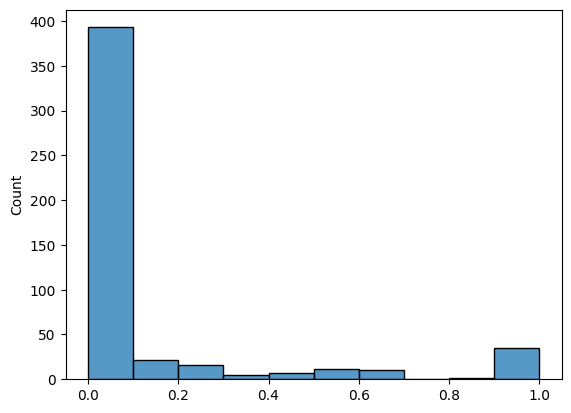

In [33]:
rouge = results[1].sort("mean", descending=True)
sns.histplot(rouge["mean"])

In [34]:
top_gens = rouge.filter(pl.col("mean") == 1).select("idx").to_series().to_list()
bottom_gens = rouge.filter(pl.col("mean") == 0)[:33].select("idx").to_series().to_list()
len(top_gens), len(bottom_gens)

(35, 33)

In [38]:
random_indeces = [retrievals["random_indeces_insertion.json"][str(i)][-20:-1] for i in range(500)]
count = 0
for i in top_gens:
    model_indeces = retrievals[f"rougel_model"][str(i)][34:50]
    for j in range(16):
        if model_indeces[j] in random_indeces[i]:
            count += 1
print(f"Intersection between random and {r}: {count}")

Intersection between random and judge_model: 95


In [37]:
random_indeces = [retrievals["random_indeces_insertion.json"][str(i)][-20:-1] for i in range(500)]
count = 0
for i in bottom_gens:
    model_indeces = retrievals[f"rougel_model"][str(i)][34:50]
    for j in range(16):
        if model_indeces[j] in random_indeces[i]:
            count += 1
print(f"Intersection between random and {r}: {count}")

Intersection between random and judge_model: 77
